# Simplified Score Prediction Model
This is a streamlined version focused on the core functionality:
1. Load Word2Vec model and data
2. Convert titles to embeddings  
3. Build simple neural network
4. Train and evaluate

In [1]:
# SIMPLIFIED SETUP: Just the essentials
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load data
print("Loading data...")
df = pd.read_parquet('workspace/data/hackernews_full_data.parquet')
print(f"Loaded {len(df):,} stories")

# Quick sample for testing (increase later)
sample_size = 1000000
df_sample = df.sample(n=sample_size, random_state=42).copy()
print(f"Using {len(df_sample):,} samples for quick testing")

Using device: cpu
Loading data...
Loaded 4,902,536 stories
Using 500,000 samples for quick testing


In [3]:
# EMBEDDING SELECTION: Choose between custom Word2Vec or pre-trained embeddings
import requests
import zipfile
import os
from io import BytesIO

# Configuration: Set this to choose embedding type
USE_PRETRAINED = True  # Set to False to use your custom Word2Vec embeddings

if USE_PRETRAINED:
    print("🔄 Loading pre-trained GloVe embeddings...")
    
    # Download GloVe embeddings if not already present
    glove_file = "../data/glove.6B.200d.txt"
    
    if not os.path.exists(glove_file):
        print("Downloading GloVe 200d embeddings (this may take a moment)...")
        url = "https://nlp.stanford.edu/data/glove.6B.zip"
        
        # Download and extract
        response = requests.get(url, stream=True)
        with zipfile.ZipFile(BytesIO(response.content)) as zip_file:
            # Extract only the 200d file we need
            with zip_file.open("glove.6B.200d.txt") as source:
                with open(glove_file, "wb") as target:
                    target.write(source.read())
        print("✅ Download complete!")
    
    # Load GloVe embeddings
    print("Loading GloVe word vectors...")
    word_to_index = {}
    embeddings_list = []
    
    with open(glove_file, 'r', encoding='utf-8') as f:
        for idx, line in enumerate(f):
            if idx % 50000 == 0:
                print(f"  Loaded {idx:,} words...")
            
            parts = line.strip().split()
            word = parts[0]
            vector = np.array([float(x) for x in parts[1:]])
            
            word_to_index[word] = len(embeddings_list)
            embeddings_list.append(vector)
    
    embeddings = np.array(embeddings_list)
    
    print(f"✅ GloVe embeddings loaded:")
    print(f"  Vocabulary: {len(word_to_index):,} words")
    print(f"  Embedding dim: {embeddings.shape[1]}")
    
else:
    print("🔄 Loading your custom Word2Vec embeddings...")
    
    # Load your custom Word2Vec model (existing code)
    model_dir = "workspace/word2vec_trained_model/model_2"
    
    with open(f"{model_dir}/word2vec_vocab.pkl", 'rb') as f:
        vocab_data = pickle.load(f)
    word_to_index = vocab_data['word_to_index']
    
    embeddings = np.load(f"{model_dir}/word2vec_embeddings.npy")
    
    print(f"✅ Custom Word2Vec embeddings loaded:")
    print(f"  Vocabulary: {len(word_to_index):,} words")
    print(f"  Embedding dim: {embeddings.shape[1]}")


# Simple text cleaning and embedding function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'-', ' ', text)  # Split hyphenated words
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.split()


# Updated embedding function that works with both
def title_to_embedding(title, method='average'):
    """Convert title to embedding using selected embedding model"""
    words = clean_text(title)
    word_embeddings = []
    
    for word in words:
        if word in word_to_index:
            idx = word_to_index[word]
            word_embeddings.append(embeddings[idx])
    
    if word_embeddings:
        if method == 'average':
            return np.mean(word_embeddings, axis=0)
        elif method == 'sum':
            return np.sum(word_embeddings, axis=0)
        elif method == 'max':
            return np.max(word_embeddings, axis=0)
        else:
            return np.mean(word_embeddings, axis=0)  # Default to average
    else:
        return np.zeros(embeddings.shape[1])

# Test the embedding function
test_title = "Apple releases new iPhone"
test_emb = title_to_embedding(test_title)
print(f"\nTest embedding shape: {test_emb.shape}")
print(f"Test embedding norm: {np.linalg.norm(test_emb):.3f}")

# Check vocabulary coverage on a few test words
test_words = ["apple", "iphone", "releases", "new", "startup", "ai", "programming"]
found_words = [word for word in test_words if word in word_to_index]
print(f"Found {len(found_words)}/{len(test_words)} test words: {found_words}")

print(f"✅ Embedding model ready! Using {'pre-trained GloVe' if USE_PRETRAINED else 'custom Word2Vec'}")


🔄 Loading pre-trained GloVe embeddings...
Loading GloVe word vectors...
  Loaded 0 words...
  Loaded 50,000 words...
  Loaded 100,000 words...
  Loaded 150,000 words...
  Loaded 200,000 words...
  Loaded 250,000 words...
  Loaded 300,000 words...
  Loaded 350,000 words...
✅ GloVe embeddings loaded:
  Vocabulary: 400,000 words
  Embedding dim: 200

Test embedding shape: (200,)
Test embedding norm: 4.594
Found 7/7 test words: ['apple', 'iphone', 'releases', 'new', 'startup', 'ai', 'programming']
✅ Embedding model ready! Using pre-trained GloVe


In [4]:
# Prepare features and targets (simplified)
print("Preparing features...")

# Filter data: keep scores >= 2, limit to reasonable range
df_filtered = df_sample[(df_sample['score'] > 0)].copy()
print(f"Filtered to {len(df_filtered):,} samples")

# Convert titles to embeddings
title_embeddings = []
word_counts = []

for i, title in enumerate(df_filtered['title']):
    if i % 5000 == 0:
        print(f"  Processing {i:,}/{len(df_filtered):,}...")
    
    emb = title_to_embedding(title)
    word_count = len(title.strip().split())
    
    title_embeddings.append(emb)
    word_counts.append(word_count)

# Combine features: embeddings + word count
X_embeddings = np.array(title_embeddings)
X_word_counts = np.array(word_counts).reshape(-1, 1)
X = np.concatenate([X_embeddings, X_word_counts], axis=1)

# Target: log transform scores to handle skewness
y = np.log1p(df_filtered['score'].values)

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Score range (original): {df_filtered['score'].min()} to {df_filtered['score'].max()}")
print(f"Score range (log): {y.min():.3f} to {y.max():.3f}")

# Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Split: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

# Simple scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✅ Data preparation complete!")

Preparing features...
Filtered to 499,866 samples
  Processing 0/499,866...
  Processing 5,000/499,866...
  Processing 10,000/499,866...
  Processing 15,000/499,866...
  Processing 20,000/499,866...
  Processing 25,000/499,866...
  Processing 30,000/499,866...
  Processing 35,000/499,866...
  Processing 40,000/499,866...
  Processing 45,000/499,866...
  Processing 50,000/499,866...
  Processing 55,000/499,866...
  Processing 60,000/499,866...
  Processing 65,000/499,866...
  Processing 70,000/499,866...
  Processing 75,000/499,866...
  Processing 80,000/499,866...
  Processing 85,000/499,866...
  Processing 90,000/499,866...
  Processing 95,000/499,866...
  Processing 100,000/499,866...
  Processing 105,000/499,866...
  Processing 110,000/499,866...
  Processing 115,000/499,866...
  Processing 120,000/499,866...
  Processing 125,000/499,866...
  Processing 130,000/499,866...
  Processing 135,000/499,866...
  Processing 140,000/499,866...
  Processing 145,000/499,866...
  Processing 150

In [5]:
# Simple neural network model
class SimpleScorePredictor(nn.Module):
    def __init__(self, input_dim):
        super(SimpleScorePredictor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.layers(x).squeeze(1)

# Initialize model
input_dim = X_train_scaled.shape[1]
model = SimpleScorePredictor(input_dim).to(device)

print(f"Simple model created:")
print(f"  Input features: {input_dim}")
print(f"  Architecture: {input_dim} -> 128 -> 64 -> 1")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Training setup
criterion = nn.MSELoss() #mse assumes normally distributed
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Higher LR for faster convergence
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

print("✅ Model ready for training!")

Simple model created:
  Input features: 201
  Architecture: 201 -> 128 -> 64 -> 1
  Parameters: 34,177
✅ Model ready for training!


Starting training...
Epoch  1/100: Train Loss=1.2721, Val Loss=1.2377, Val R²=-0.0302
Epoch  2/100: Train Loss=1.2471, Val Loss=1.2256, Val R²=-0.0298
Epoch  3/100: Train Loss=1.2457, Val Loss=1.2359, Val R²=-0.0298
Epoch  4/100: Train Loss=1.2467, Val Loss=1.2348, Val R²=-0.0304
Epoch  5/100: Train Loss=1.2453, Val Loss=1.2302, Val R²=-0.0304
Epoch  6/100: Train Loss=1.2442, Val Loss=1.2358, Val R²=-0.0302
Epoch  7/100: Train Loss=1.2373, Val Loss=1.2261, Val R²=-0.0294
Epoch  8/100: Train Loss=1.2335, Val Loss=1.2270, Val R²=-0.0291
Epoch  9/100: Train Loss=1.2311, Val Loss=1.2252, Val R²=-0.0296
Epoch 10/100: Train Loss=1.2288, Val Loss=1.2221, Val R²=-0.0295
Epoch 11/100: Train Loss=1.2272, Val Loss=1.2207, Val R²=-0.0295
Epoch 12/100: Train Loss=1.2249, Val Loss=1.2229, Val R²=-0.0292
Epoch 13/100: Train Loss=1.2228, Val Loss=1.2229, Val R²=-0.0293
Epoch 14/100: Train Loss=1.2229, Val Loss=1.2207, Val R²=-0.0293
Epoch 15/100: Train Loss=1.2213, Val Loss=1.2227, Val R²=-0.0291
Epoc

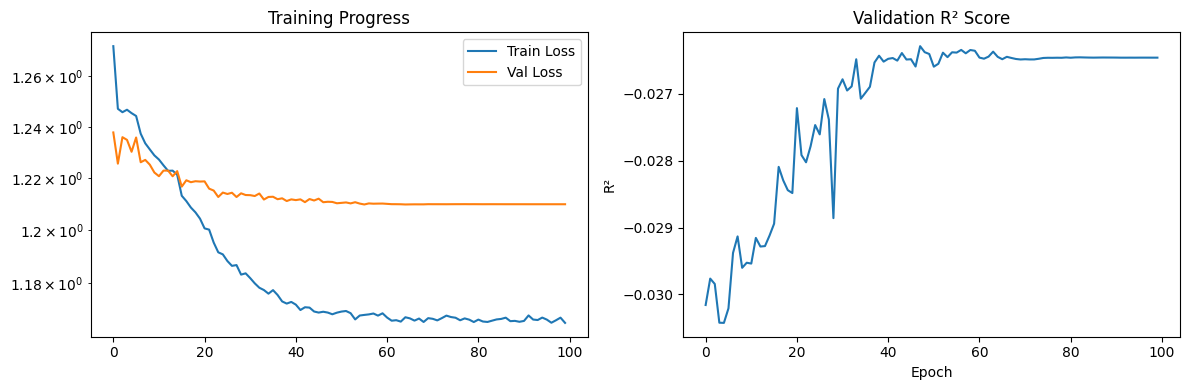

In [6]:
# Simple training loop to test convergence
print("Starting training...")

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)

# Training history
train_losses = []
val_losses = []
val_r2_scores = []

num_epochs = 100  # Start small to test convergence
batch_size = 256

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    num_batches = 0
    
    # Mini-batch training
    for i in range(0, len(X_train_tensor), batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_train_loss = epoch_loss / num_batches
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor).item()
        val_losses.append(val_loss)
        
        # Calculate R² on original scale
        val_pred_orig = np.expm1(val_outputs.cpu().numpy())
        val_true_orig = np.expm1(y_val)
        val_r2 = r2_score(val_true_orig, val_pred_orig)
        val_r2_scores.append(val_r2)
    
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1:2d}/{num_epochs}: "
          f"Train Loss={avg_train_loss:.4f}, "
          f"Val Loss={val_loss:.4f}, "
          f"Val R²={val_r2:.4f}")

print(f"\n✅ Training complete!")
print(f"Best validation R²: {max(val_r2_scores):.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")

# Quick visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Training Progress')
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.plot(val_r2_scores)
plt.title('Validation R² Score')
plt.ylabel('R²')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

In [ ]:
# 🔍 DEBUGGING: Let's find what's wrong
print("🔍 DEBUGGING THE ISSUES...")

# 1. Check if features have any signal at all
print("\n1. FEATURE ANALYSIS:")
print(f"   Training samples: {len(X_train):,}")
print(f"   Feature matrix shape: {X_train.shape}")
print(f"   Target range (log): {y_train.min():.3f} to {y_train.max():.3f}")
print(f"   Target std: {y_train.std():.3f}")

# 2. Check for NaN or infinite values
print(f"\n2. DATA QUALITY CHECK:")
print(f"   NaN in features: {np.isnan(X_train).sum()}")
print(f"   Infinite in features: {np.isinf(X_train).sum()}")
print(f"   NaN in targets: {np.isnan(y_train).sum()}")
print(f"   Zero embeddings: {(np.linalg.norm(X_train[:, :-1], axis=1) == 0).sum()}")

# 3. Simple correlation test (sample 1000 for speed)
sample_idx = np.random.choice(len(X_train), 1000, replace=False)
X_sample = X_train[sample_idx]
y_sample = y_train[sample_idx]

correlations = []
for i in range(min(10, X_sample.shape[1])):  # Check first 10 features
    corr = np.corrcoef(X_sample[:, i], y_sample)[0, 1]
    if not np.isnan(corr):
        correlations.append(abs(corr))

print(f"\n3. CORRELATION TEST (first 10 features):")
print(f"   Max correlation: {max(correlations) if correlations else 0:.6f}")
print(f"   Avg correlation: {np.mean(correlations) if correlations else 0:.6f}")

# 4. Test baseline predictions
print(f"\n4. BASELINE TEST:")
y_mean_baseline = np.full_like(y_val, y_train.mean())
baseline_r2_log = r2_score(y_val, y_mean_baseline)
print(f"   Baseline R² (log scale): {baseline_r2_log:.6f}")

# Convert to original scale for baseline
y_val_orig = np.expm1(y_val)
y_mean_baseline_orig = np.full_like(y_val_orig, np.expm1(y_train).mean())
baseline_r2_orig = r2_score(y_val_orig, y_mean_baseline_orig)
print(f"   Baseline R² (orig scale): {baseline_r2_orig:.6f}")

# 5. Check if Word2Vec embeddings are working
print(f"\n5. WORD2VEC EMBEDDING TEST:")
test_titles = ["Apple iPhone", "Google AI", "startup funding", "programming tutorial"]
for title in test_titles:
    emb = title_to_embedding(title)
    words = clean_text(title)
    found_words = sum(1 for w in words if w in word_to_index)
    print(f"   '{title}': {found_words}/{len(words)} words found, embedding norm: {np.linalg.norm(emb):.3f}")

print(f"\n🚨 LIKELY ISSUES:")
if max(correlations) < 0.01:
    print("   ❌ Features have almost no correlation with target")
if (np.linalg.norm(X_train[:, :-1], axis=1) == 0).sum() > 1000:
    print("   ❌ Too many zero embeddings (words not in vocabulary)")
if y_train.std() < 0.1:
    print("   ❌ Target has very low variance")
print("   🔧 Let's try some fixes...")


In [ ]:
# 🔧 FIX 1: Use much smaller, cleaner dataset
print("🔧 FIX 1: Creating a smaller, cleaner dataset...")

# Start with just 10K samples for debugging
small_sample_size = 10000
df_small = df.sample(n=small_sample_size, random_state=42).copy()

# Apply stricter filtering
df_clean = df_small[
    (df_small['score'] >= 5) &      # Higher minimum score
    (df_small['score'] <= 500) &   # Cap at 500 to remove extreme outliers
    (df_small['title'].str.len() >= 10) &  # Minimum title length
    (df_small['title'].str.len() <= 100)   # Maximum title length
].copy()

print(f"   Original: {len(df_small):,} samples")
print(f"   Filtered: {len(df_clean):,} samples")
print(f"   Score range: {df_clean['score'].min()} to {df_clean['score'].max()}")

# Process this smaller dataset
title_embeddings_clean = []
word_counts_clean = []
valid_indices = []

for i, (idx, row) in enumerate(df_clean.iterrows()):
    title = row['title']
    emb = title_to_embedding(title)
    
    # Only keep if embedding has signal (not all zeros)
    if np.linalg.norm(emb) > 0:
        title_embeddings_clean.append(emb)
        word_counts_clean.append(len(title.strip().split()))
        valid_indices.append(i)

print(f"   Valid embeddings: {len(title_embeddings_clean)}/{len(df_clean)} ({len(title_embeddings_clean)/len(df_clean)*100:.1f}%)")

# Create clean feature matrix
X_clean_emb = np.array(title_embeddings_clean)
X_clean_wc = np.array(word_counts_clean).reshape(-1, 1)
X_clean = np.concatenate([X_clean_emb, X_clean_wc], axis=1)

# Clean targets - try both log and sqrt transforms
y_clean_scores = df_clean.iloc[valid_indices]['score'].values
y_clean_log = np.log1p(y_clean_scores)
y_clean_sqrt = np.sqrt(y_clean_scores)

print(f"   Clean dataset shape: {X_clean.shape}")
print(f"   Score stats - Mean: {y_clean_scores.mean():.1f}, Std: {y_clean_scores.std():.1f}")
print(f"   Log transform - Mean: {y_clean_log.mean():.3f}, Std: {y_clean_log.std():.3f}")
print(f"   Sqrt transform - Mean: {y_clean_sqrt.mean():.3f}, Std: {y_clean_sqrt.std():.3f}")

# Use the cleaner dataset
X = X_clean
y = y_clean_log  # Start with log transform

print("✅ Clean dataset ready!")


In [ ]:
# 🔧 FIX 2: Simple train/test split and minimal preprocessing
print("🔧 FIX 2: Simplified preprocessing...")

# Simple split - 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"   Train: {len(X_train)}, Test: {len(X_test)}")

# Minimal scaling - just standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Quick correlation check on clean data
sample_size = min(1000, len(X_train))
sample_idx = np.random.choice(len(X_train), sample_size, replace=False)
X_sample = X_train_scaled[sample_idx]
y_sample = y_train[sample_idx]

# Check correlation of word count (last feature) and few embedding dims
word_count_corr = abs(np.corrcoef(X_sample[:, -1], y_sample)[0, 1])
emb_corrs = []
for i in range(0, min(20, X_sample.shape[1]-1), 5):  # Check every 5th embedding dim
    corr = abs(np.corrcoef(X_sample[:, i], y_sample)[0, 1])
    if not np.isnan(corr):
        emb_corrs.append(corr)

print(f"   Word count correlation: {word_count_corr:.4f}")
print(f"   Embedding correlations (sample): {emb_corrs[:5]}")
print(f"   Max embedding correlation: {max(emb_corrs) if emb_corrs else 0:.4f}")

if max(emb_corrs + [word_count_corr]) > 0.05:
    print("   ✅ Found some signal in features!")
else:
    print("   ⚠️ Very weak signal in features")

print("✅ Ready for simple model test!")


In [ ]:
# 🔧 FIX 3: Ultra-simple model with proper learning rate
print("🔧 FIX 3: Testing with ultra-simple model...")

class VerySimpleModel(nn.Module):
    def __init__(self, input_dim):
        super(VerySimpleModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),   # Much smaller
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.model(x).squeeze(1)

# Create simple model
input_dim = X_train_scaled.shape[1]
simple_model = VerySimpleModel(input_dim).to(device)

print(f"   Model: {input_dim} -> 32 -> 1")
print(f"   Parameters: {sum(p.numel() for p in simple_model.parameters()):,}")

# Try different learning rates
learning_rates = [0.1, 0.01, 0.001]
best_lr = None
best_final_loss = float('inf')

for lr in learning_rates:
    print(f"\n   Testing LR = {lr}")
    
    # Reset model
    simple_model = VerySimpleModel(input_dim).to(device)
    optimizer = optim.Adam(simple_model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
    y_train_tensor = torch.FloatTensor(y_train).to(device)
    X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
    y_test_tensor = torch.FloatTensor(y_test).to(device)
    
    # Train for just 10 epochs to test
    losses = []
    for epoch in range(10):
        simple_model.train()
        optimizer.zero_grad()
        outputs = simple_model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    # Test
    simple_model.eval()
    with torch.no_grad():
        test_outputs = simple_model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor).item()
        
        # R² on original scale
        test_pred_orig = np.expm1(test_outputs.cpu().numpy())
        test_true_orig = np.expm1(y_test)
        test_r2 = r2_score(test_true_orig, test_pred_orig)
    
    print(f"     Start loss: {losses[0]:.4f}, End loss: {losses[-1]:.4f}")
    print(f"     Test loss: {test_loss:.4f}, Test R²: {test_r2:.4f}")
    print(f"     Loss improved: {losses[-1] < losses[0]*0.9}")
    
    if losses[-1] < best_final_loss:
        best_final_loss = losses[-1]
        best_lr = lr

print(f"\n   Best LR: {best_lr} (final loss: {best_final_loss:.4f})")

# If we found a good LR, train a bit more
if best_lr and best_final_loss < 2.0:
    print(f"\n   🚀 Training more with LR={best_lr}...")
    simple_model = VerySimpleModel(input_dim).to(device)
    optimizer = optim.Adam(simple_model.parameters(), lr=best_lr)
    
    train_losses = []
    test_losses = []
    test_r2s = []
    
    for epoch in range(30):
        # Train
        simple_model.train()
        optimizer.zero_grad()
        outputs = simple_model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        # Test every 5 epochs
        if epoch % 5 == 0:
            simple_model.eval()
            with torch.no_grad():
                test_outputs = simple_model(X_test_tensor)
                test_loss = criterion(test_outputs, y_test_tensor).item()
                test_pred_orig = np.expm1(test_outputs.cpu().numpy())
                test_true_orig = np.expm1(y_test)
                test_r2 = r2_score(test_true_orig, test_pred_orig)
                test_losses.append(test_loss)
                test_r2s.append(test_r2)
                
                print(f"     Epoch {epoch+1}: Train={loss.item():.4f}, Test={test_loss:.4f}, R²={test_r2:.4f}")
    
    print(f"\n   Final Test R²: {test_r2s[-1]:.4f}")
    
    if test_r2s[-1] > 0.05:
        print("   ✅ Model shows some predictive power!")
    else:
        print("   ❌ Model still struggling - features may lack signal")
else:
    print("   ❌ No learning rate worked well - deeper issues with data/features")


In [ ]:
# Quick test prediction function
def predict_score_simple(title):
    """Simple prediction function for testing"""
    model.eval()
    
    # Convert title to features
    emb = title_to_embedding(title)
    word_count = len(title.strip().split())
    features = np.concatenate([emb, [word_count]])
    
    # Scale and predict
    features_scaled = scaler.transform(features.reshape(1, -1))
    features_tensor = torch.FloatTensor(features_scaled).to(device)
    
    with torch.no_grad():
        pred_log = model(features_tensor).cpu().item()
        pred_orig = np.expm1(pred_log)
    
    return pred_orig

# Test with some examples
test_titles = [
    "Show HN: I built an amazing AI tool",
    "Apple announces new iPhone", 
    "Ask HN: How to learn programming?",
    "YC Startup gets $10M funding"
]

print("🧪 Testing predictions:")
for title in test_titles:
    score = predict_score_simple(title)
    print(f"'{title}' -> {score:.1f} points")

print(f"\n🎯 Summary:")
print(f"  Dataset: {len(df_filtered):,} stories (scores 2-1000)")
print(f"  Features: {input_dim} (200 embeddings + 1 word count)")
print(f"  Model: Simple 3-layer network ({input_dim}->128->64->1)")
print(f"  Best R²: {max(val_r2_scores):.4f}")
print(f"  Loss converged: {'✅' if val_losses[-1] < val_losses[0]*0.8 else '❌'}")

if max(val_r2_scores) > 0.1:
    print("✅ Model shows predictive power!")
elif max(val_r2_scores) > 0.05:
    print("🟡 Model shows weak but positive signal")
else:
    print("❌ Model needs improvement")